<a href="https://colab.research.google.com/github/gitHubAndyLee2020/FinancialBERT/blob/main/financial_bert_rag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FinancialBERT RAG System

### API Keys

In [ ]:
%%writefile .env
BING_SEARCH_API_KEY=<YOUR_BING_SEARCH_API_KEY>
POLYGON_API_KEY=<YOUR_POLYGON_API_KEY>
COHERE_API_KEY=<YOUR_COHERE_API_KEY>

### Files Uploading

In [ ]:
# Upload `model_regressor_weight_v2.pth` and `tickers_and_names.csv` here
from google.colab import files

uploaded = files.upload()

### Package Installations

In [ ]:
!pip install python-dotenv fuzzywuzzy python-Levenshtein cohere streamlit pyngrok

### Name-Ticker Module

In [ ]:
%%writefile name_ticker_module.py
import pandas as pd
from fuzzywuzzy import process  # Assuming fuzzywuzzy is used for string matching

# Load the CSV file into a DataFrame
tickers_and_names = pd.read_csv('tickers_and_names.csv')

def find_similar_names_and_tickers(query, threshold=80):
    # Find matches above a certain score threshold
    results = process.extractBests(query, tickers_and_names["Name"], score_cutoff=threshold)

    # Retrieve both name and ticker for each match
    matched_pairs = []
    for result in results:
        matched_name = result[0]
        matched_index = tickers_and_names[tickers_and_names["Name"] == matched_name].index[0]
        matched_ticker = tickers_and_names.loc[matched_index, "Ticker"]
        matched_pairs.append((matched_name, matched_ticker))

    return matched_pairs

### Bing Search Module

In [ ]:
%%writefile bing_search_module.py
from dotenv import load_dotenv
import requests
import os
from datetime import datetime

load_dotenv()  # This loads the variables from .env

BING_SEARCH_API_KEY = os.getenv('BING_SEARCH_API_KEY')
search_url = "https://api.bing.microsoft.com/v7.0/news/search"

def bing_search_news(company_name: str):
    headers = {"Ocp-Apim-Subscription-Key" : BING_SEARCH_API_KEY}
    params  = {
        "q": f"{company_name} stock price and finance news",
        "mkt": "en-US",  # Search in English
        "textDecorations": True,
        "textFormat": "HTML",
        "freshness": "Month",
        "count": 100,
    }
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()

    current_month = datetime.now().month
    current_year = datetime.now().year

    filtered_articles = []
    for article in search_results["value"]:
        # Adjust the date format
        date_str = article["datePublished"]
        # Trimming microseconds to six digits and replacing 'Z' with '+00:00'
        date_str = date_str[:-2] + date_str[-1].replace('Z', '+00:00')
        published_date = datetime.fromisoformat(date_str)
        if published_date.month == current_month and published_date.year == current_year:
            filtered_articles.append(article)

    return filtered_articles

### Polygon Module

In [ ]:
%%writefile polygon_module.py
from dotenv import load_dotenv
import requests
import os

load_dotenv()  # This loads the variables from .env

POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

# Monthly Stock Price History Data
def get_stock_price_history(ticker: str, start_date: str, end_date: str):
  # Polygon.io API URL for AAPL stock data
  url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/month/{start_date}/{end_date}?apiKey={POLYGON_API_KEY}'

  # Make the GET request
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Parse the JSON data
      data = response.json()
      return [result['vw'] for result in data['results']]
  else:
      print(f'Failed to retrieve data: {response.status_code}')

### Calendar Module

In [ ]:
%%writefile calendar_module.py
import datetime
import calendar

def get_first_last_days():
    # Get the current date
    current_date = datetime.date.today()

    # Calculate the first day of the month 5 months ago
    past_year, past_month = current_date.year, current_date.month
    for _ in range(5):  # For 5 months
        if past_month == 1:
            past_month = 12
            past_year -= 1
        else:
            past_month -= 1
    past_first_day = datetime.date(past_year, past_month, 1)

    # Calculate the last day of the current month
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    current_month_last_day = datetime.date(current_date.year, current_date.month, last_day)

    # Format the dates to the desired format
    past_month_first_day_str = past_first_day.strftime('%Y-%m-%d')
    current_month_last_day_str = current_month_last_day.strftime('%Y-%m-%d')

    # Generate list of year-month labels from 5 months ago to the next month
    year_month_labels = []
    year, month = past_year, past_month
    for _ in range(7):  # Including the current month and the next month
        year_month_labels.append(f"{year}-{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1

    return past_month_first_day_str, current_month_last_day_str, year_month_labels

### Cohere Rerank Module

In [ ]:
%%writefile cohere_rerank_module.py
from dotenv import load_dotenv
import os
import cohere

load_dotenv()  # This loads the variables from .env

COHERE_API_KEY = os.getenv('COHERE_API_KEY')

co = cohere.Client(COHERE_API_KEY)

def rerank_search_results(company_name: str, search_results: list[str], top_n: int):
    query = f"Filter and prioritize news headlines explicitly discussing factors influencing {company_name}'s stock price, including market trends, financial reports, corporate announcements, and industry-specific news impacting {company_name}'s performance."
    results = co.rerank(model="rerank-english-v2.0", query=query, documents=search_results, top_n=top_n)
    return [result.document['text'] for result in results]

### FinancialBERT Module

In [ ]:
%%writefile financial_bert_module.py
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        # Load the FinBERT model
        self.finbert = BertModel.from_pretrained(finbert_model_name)

        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Get embeddings from FinBERT
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

if not ('model' in globals()):
    model = FinBERTRegressor()
    model.to(device)
    model.regressor.load_state_dict(torch.load('model_regressor_weight_v2.pth'))

if not ('tokenizer' in globals()):
    tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

def predict_monthly_stock_price_change_rate(text: str):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move the inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output
    output = model(**inputs)

    return output.item()

### Module Tests

Company Name Search:
Name: Apple Inc., Ticker: AAPL



Bing Search News Articles:
- APLE stock has gone up by 0.06%, with a monthly decline of -1.42% and a quarterly surge of 3.88%. The volatility ratio for the week is 2.39%, and the volatility levels for the last 30 days are 2.21% for Apple Hospitality REIT Inc The simple moving average for the last 20
- The stock of Apple Inc (AAPL) has gone up by 0.67% for the week, with a 9.93% rise in the past month and a 0.94% rise in the past quarter. The volatility ratio for the week is 1.17%, and the volatility levels for the past 30 days are 1.
- Apple ( AAPL) stock is stuck in a trading range. This is good for near-term expiring covered call option plays and out-of-the-money short put plays. Investors can make extra income with these trades.
- Check out the top iPhone deals for Black Friday &amp; Cyber Monday, featuring all the best prepaid, carrier &amp; unlocked Apple iPhone offers.BOSTON, MASS.
- Save on iPhone 13, 14, 15 &amp; 15 Pro dea

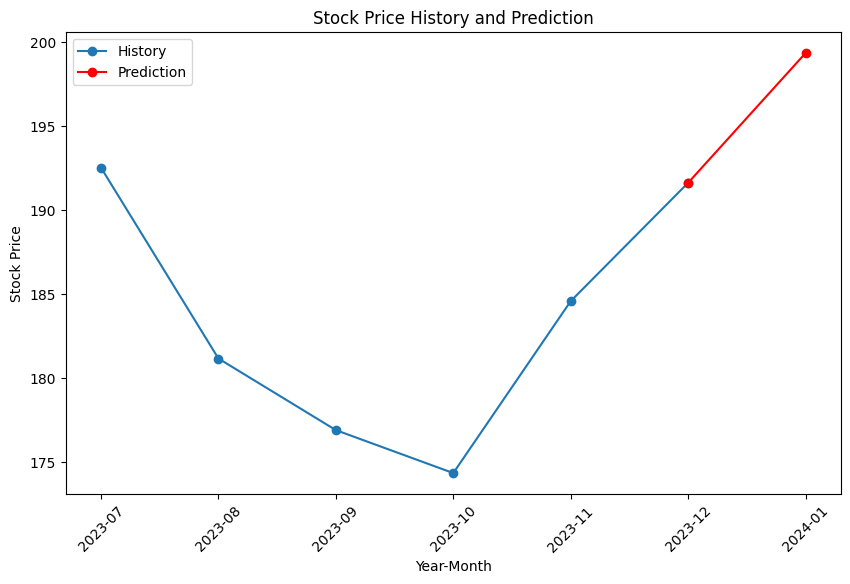

In [22]:
from name_ticker_module import find_similar_names_and_tickers
from bing_search_module import bing_search_news
from polygon_module import get_stock_price_history
from calendar_module import get_first_last_days
from cohere_rerank_module import rerank_search_results
from financial_bert_module import predict_monthly_stock_price_change_rate
import matplotlib.pyplot as plt

# Company Name Search
user_input = "Apple"
search_results = find_similar_names_and_tickers(user_input)
name, ticker = search_results[0]
print("Company Name Search:")
print(f"Name: {name}, Ticker: {ticker}")
print("\n\n")

this_month_articles = bing_search_news(name)
articles_content = [article['description'] for article in this_month_articles]
print("Bing Search News Articles:")
for article in articles_content:
    print("-", article)
print("\n\n")

reranked_articles_content = rerank_search_results(name, articles_content, 5)
print("Cohere Reranked Articles:")
for index, article in enumerate(reranked_articles_content):
    print(f"{index + 1}.", article)
print("\n\n")

concatenated_articles_content = " ".join(reranked_articles_content)

monthly_stock_price_change_rate = predict_monthly_stock_price_change_rate(concatenated_articles_content)
print("FinancialBERT Monthly Stock Price Change Rate:")
print(f"{monthly_stock_price_change_rate * 100}% change from current month's stock price (vw)")
print("\n\n")

past_month_first_day_str, current_month_last_day_str, year_month_labels = get_first_last_days()
stock_price_history = get_stock_price_history(ticker, past_month_first_day_str, current_month_last_day_str)
predicted_next_month_stock_price = stock_price_history[-1] * (1 + monthly_stock_price_change_rate)
stock_price_history.append(predicted_next_month_stock_price)
print("Polygon Stock Price History:")
if len(year_month_labels) != len(stock_price_history):
    print("Error: Length of year_month_labels and stock_price_history do not match.")
    exit()
for index, year_month_label in enumerate(year_month_labels):
    if index == len(year_month_labels) - 1:
        print(f"{year_month_label} stock price (vw): {stock_price_history[index]:.2f} (predicted)")
    else:
      print(f"{year_month_label} stock price (vw): {stock_price_history[index]:.2f}")
print("\n\n")

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(year_month_labels[:-1], stock_price_history[:-1], label='History', marker='o')
plt.plot(year_month_labels[-2:], stock_price_history[-2:], label='Prediction', color='red', marker='o')

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Stock Price')
plt.title('Stock Price History and Prediction')
plt.xticks(rotation=45)

# Adding legend
plt.legend()

# Show the plot
plt.show()

### Streamlit Interface

In [ ]:
!ngrok config add-authtoken <YOUR_NGROK_AUTH_TOKEN>

In [ ]:
%%writefile streamlit_app.py
import streamlit as st
from name_ticker_module import find_similar_names_and_tickers
from bing_search_module import bing_search_news
from polygon_module import get_stock_price_history
from calendar_module import get_first_last_days
from cohere_rerank_module import rerank_search_results
from financial_bert_module import predict_monthly_stock_price_change_rate
import matplotlib.pyplot as plt

# Streamlit app layout
st.title('Stock Analysis and Prediction')

# Company Name Search
user_input = st.text_input("Enter a company name", "Tesla")
if user_input:
    search_results = find_similar_names_and_tickers(user_input)
    option = st.selectbox('Choose a company:', search_results)
    name, ticker = option

    calculate_button = st.button('Calculate')
    if calculate_button:
        this_month_articles = bing_search_news(name)
        articles_content = [article['description'] for article in this_month_articles]

        reranked_articles_content = rerank_search_results(name, articles_content, 5)
        st.subheader("Cohere Reranked Articles:")
        for article in reranked_articles_content:
            st.write("-", article)

        concatenated_articles_content = " ".join(reranked_articles_content)
        monthly_stock_price_change_rate = predict_monthly_stock_price_change_rate(concatenated_articles_content)

        past_month_first_day_str, current_month_last_day_str, year_month_labels = get_first_last_days()
        stock_price_history = get_stock_price_history(ticker, past_month_first_day_str, current_month_last_day_str)
        predicted_next_month_stock_price = stock_price_history[-1] * (1 + monthly_stock_price_change_rate)
        stock_price_history.append(predicted_next_month_stock_price)

        # Plotting the data
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(year_month_labels[:-1], stock_price_history[:-1], label='History', marker='o')
        ax.plot(year_month_labels[-2:], stock_price_history[-2:], label='Prediction', color='red', marker='o')

        # Adding labels and title
        ax.set_xlabel('Year-Month')
        ax.set_ylabel('Stock Price')
        ax.set_title('Stock Price History and Prediction')
        plt.xticks(rotation=45)

        # Adding legend
        ax.legend()

        # Show the plot in Streamlit
        st.pyplot(fig)

In [ ]:
# Import required libraries
import threading
from pyngrok import ngrok

# Function to run Streamlit
def run_streamlit():
    !streamlit run streamlit_app.py --server.port=8501

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit)
thread.start()

# Terminate any existing ngrok tunnels
ngrok.kill()

# Open a new ngrok tunnel to the Streamlit app
public_url = ngrok.connect(8501)
print('Streamlit app URL:', public_url)